In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os

from utils.calibration import calibrate
from utils.camera import build_camera_matrix, get_rotated_camera
from utils.homography import get_homography, apply_homography
from utils.plotting import points_to_image, plot_points_as_image, plot_multiple_images, get_title_from_orientation
from utils.points import generate_points, generate_points_random, jitter_image_points
from utils.results import get_relative_error, display_relative_error, write_results, write_errors

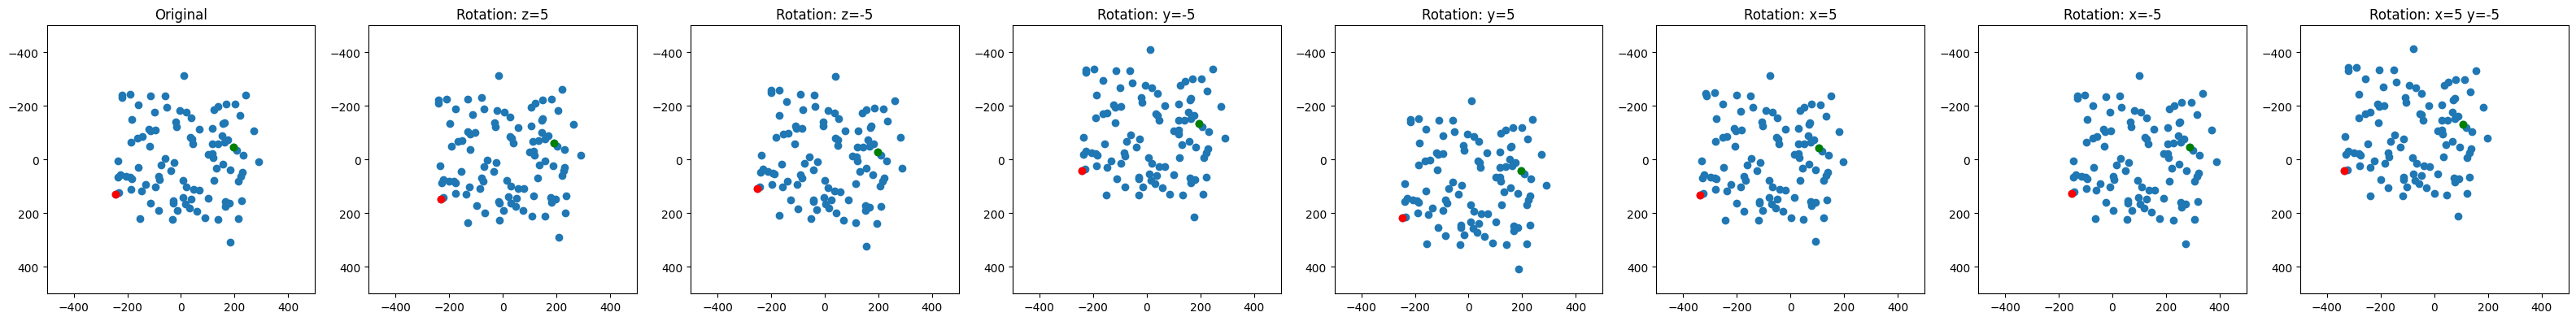

In [ ]:
# experiment loop

# original camera
P, K, C = build_camera_matrix(1000, 1000, 0, 0, 0, np.array([0, 0, 0, 1]))

# orientations (degree rotations in (x, y, z))
orientations = [
    (0, 0, 0),
    (0, 0, 10),
    (0, 0, -10),
    (0, -10, 0),
    (0, 10, 0),
    (10, 0, 0),
    (-10, 0, 0),
    (10, -10, 0)
]

name = 'one_combine'

cams = [get_rotated_camera(K, C, *o, deg=True) for o in orientations]
titles = [get_title_from_orientation(o) for o in orientations]

results = []
errors = []
for i in range(10):
    # generate points
    points_3dh = generate_points_random(100)

    points_2dh = [points_3dh @ cam.T for cam in cams]
    points_2d = [pts[:, :2] / pts[:, 2].reshape(-1, 1) for pts in points_2dh]
    points_2d_jittered = [jitter_image_points(pts, sigma=1) for pts in points_2d]

    
    recovered_k = calibrate(*points_2d_jittered)
    error = get_relative_error(K, recovered_k)

    results.append(recovered_k)
    errors.append(error)

write_results(results, f'results/results_{name}.csv')
write_errors(errors, f'results/errors_{name}.csv')

plot_points_as_image(*points_2d, titles=titles, w=1000, h=1000)


Output:
[[ 1.00578383e+03  2.45137177e+00  4.23995005e+00]
 [-0.00000000e+00  9.47917204e+02  1.46259096e+01]
 [ 1.34279317e-15 -7.55904423e-15  1.00000000e+00]]
fx error: 0.00578383365310242
fy error: 0.052082795833209614
skew error: 2.4513717655162273
u error: 4.239950045047639
v error: 14.625909594244746


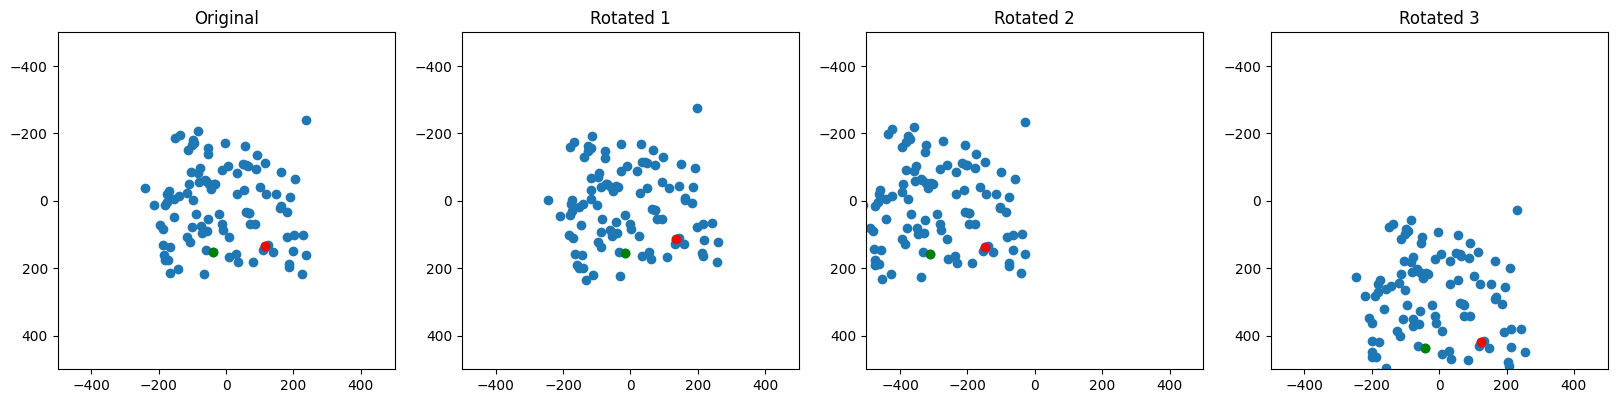

In [3]:
# full flow mimicking paper result
P, K, C = build_camera_matrix(1000, 1000, 0, 0, 0, np.array([0, 0, 0, 1]))

points_3dh = generate_points_random(100)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

cams = [
    P,
    get_rotated_camera(K, C, z=np.pi/20),
    get_rotated_camera(K, C, x=np.pi/12),
    get_rotated_camera(K, C, y=np.pi/12),
]

titles = ['Original'] + [f'Rotated {i}' for i in range(1, len(cams))]

points_2dh = [points_3dh @ cam.T for cam in cams]
points_2d = [pts[:, :2] / pts[:, 2].reshape(-1, 1) for pts in points_2dh]

points_2d_jittered = [jitter_image_points(pts, sigma=0.5) for pts in points_2d]
# points_2d_jittered = points_2d

output = calibrate(points_2d_orig, *points_2d_jittered)
print("Output:")
print(output)

error = get_relative_error(K, output)
display_relative_error(error)

plot_points_as_image(*points_2d_jittered, titles=titles, w=1000, h=1000)


In [2]:
# set up original camera matrix
f = 300
u = f // 2
v = f / 2

P, K, C = build_camera_matrix(f, f, u, v, 0, np.array([0, 0, 0, 1]))
P

array([[300.,   0., 150.,   0.],
       [  0., 300., 150.,   0.],
       [  0.,   0.,   1.,   0.]])

In [3]:
P_30z = get_rotated_camera(K, C, z=np.pi/6)
P_15x = get_rotated_camera(K, C, x=np.pi/12)
P_30y = get_rotated_camera(K, C, y=np.pi/6)

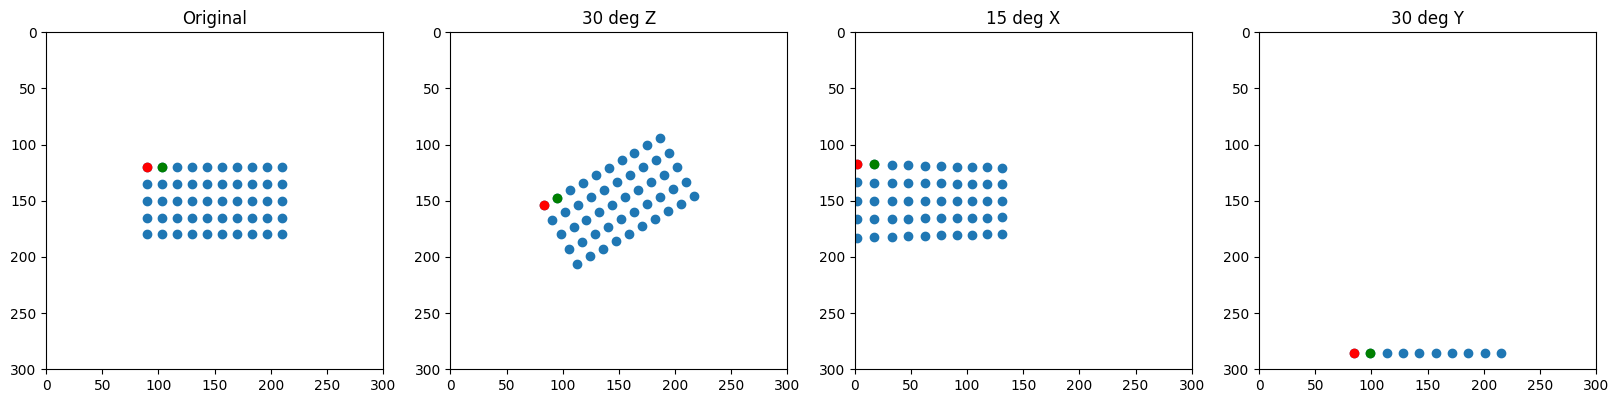

In [4]:
# when working with creating the image, we need to flip the y axis, and make sure that the axis order is correct (ij does top-down, left-right)
points_3dh = generate_points(5, 10)
# points_3dh = generate_points_random(15)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

points_2dh_30z = points_3dh @ P_30z.T
points_2d_30z = points_2dh_30z[:, :2] / points_2dh_30z[:, 2].reshape(-1, 1)

points_2dh_15x = points_3dh @ P_15x.T
points_2d_15x = points_2dh_15x[:, :2] / points_2dh_15x[:, 2].reshape(-1, 1)

# an image where not all points are visible
points_2dh_30y = points_3dh @ P_30y.T
points_2d_30y = points_2dh_30y[:, :2] / points_2dh_30y[:, 2].reshape(-1, 1)

# apply gaussian noise
# points_2d_orig = jitter_image_points(points_2d_orig, sigma=1)
# points_2d_30z = jitter_image_points(points_2d_30z, sigma=1)
# points_2d_15x = jitter_image_points(points_2d_15x, sigma=1)
# points_2d_30y = jitter_image_points(points_2d_30y, sigma=1)

plot_points_as_image(points_2d_orig, points_2d_30z, points_2d_15x, points_2d_30y, titles=['Original', '30 deg Z', '15 deg X', '30 deg Y'])

In [5]:
if not os.path.exists('data/synthetic'):
    os.makedirs('data/synthetic')

# TODO: make convenience function to deal with saving/loading data
if not os.path.exists('data/synthetic/image_orig.pkl'):
    image_orig = points_to_image(points_2d_orig)
    with open('data/synthetic/image_orig.pkl', 'wb') as f:
        pkl.dump(image_orig, f)
else:
    with open('data/synthetic/image_orig.pkl', 'rb') as f:
        image_orig = pkl.load(f)

if not os.path.exists('data/synthetic/image_30z.pkl'):
    image_30z = points_to_image(points_2d_30z)
    with open('data/synthetic/image_30z.pkl', 'wb') as f:
        pkl.dump(image_30z, f)
else:
    with open('data/synthetic/image_30z.pkl', 'rb') as f:
        image_30z = pkl.load(f)

if not os.path.exists('data/synthetic/image_15x.pkl'):
    image_15x = points_to_image(points_2d_15x)
    with open('data/synthetic/image_15x.pkl', 'wb') as f:
        pkl.dump(image_15x, f)
else:
    with open('data/synthetic/image_15x.pkl', 'rb') as f:
        image_15x = pkl.load(f)

if not os.path.exists('data/synthetic/image_30y.pkl'):
    image_30y = points_to_image(points_2d_30y)
    with open('data/synthetic/image_30y.pkl', 'wb') as f:
        pkl.dump(image_30y, f)
else:
    with open('data/synthetic/image_30y.pkl', 'rb') as f:
        image_30y = pkl.load(f)



H_30z = get_homography(points_2d_30z, points_2d_orig, normalize=True)
H_15x = get_homography(points_2d_15x, points_2d_orig, normalize=True)
H_30y = get_homography(points_2d_30y, points_2d_orig, normalize=True)
rectified_image_30z = apply_homography(image_30z, H_30z, (0, 0, 300, 300))
rectified_image_15x = apply_homography(image_15x, H_15x, (0, 0, 300, 300))
rectified_image_30y = apply_homography(image_30y, H_30y, (0, 0, 300, 300))

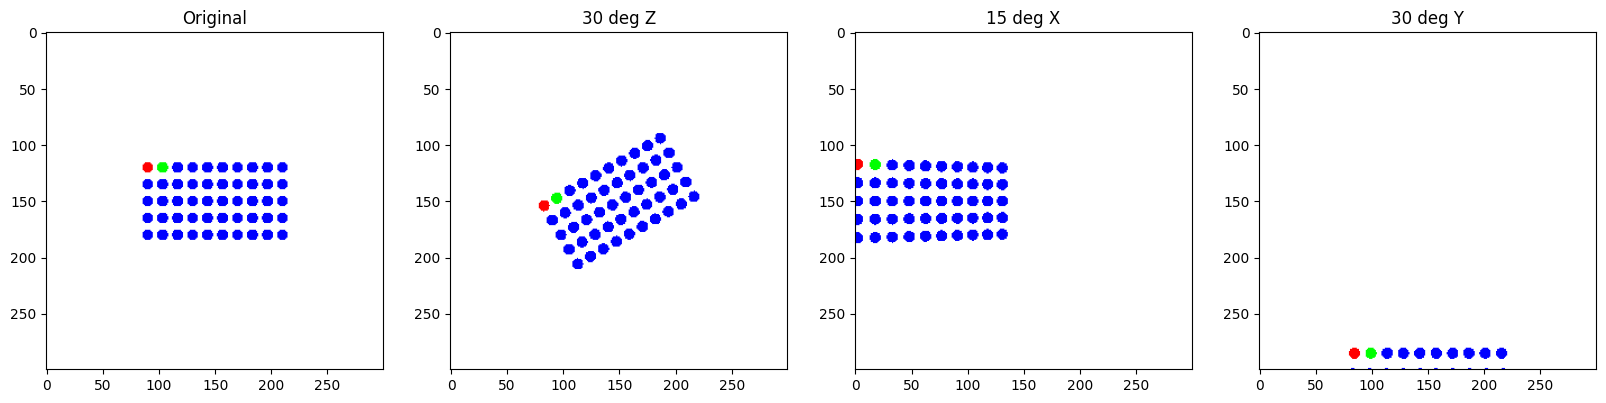

In [6]:
plot_multiple_images(image_orig, image_30z, image_15x, image_30y, titles=['Original', '30 deg Z', '15 deg X', '30 deg Y'])

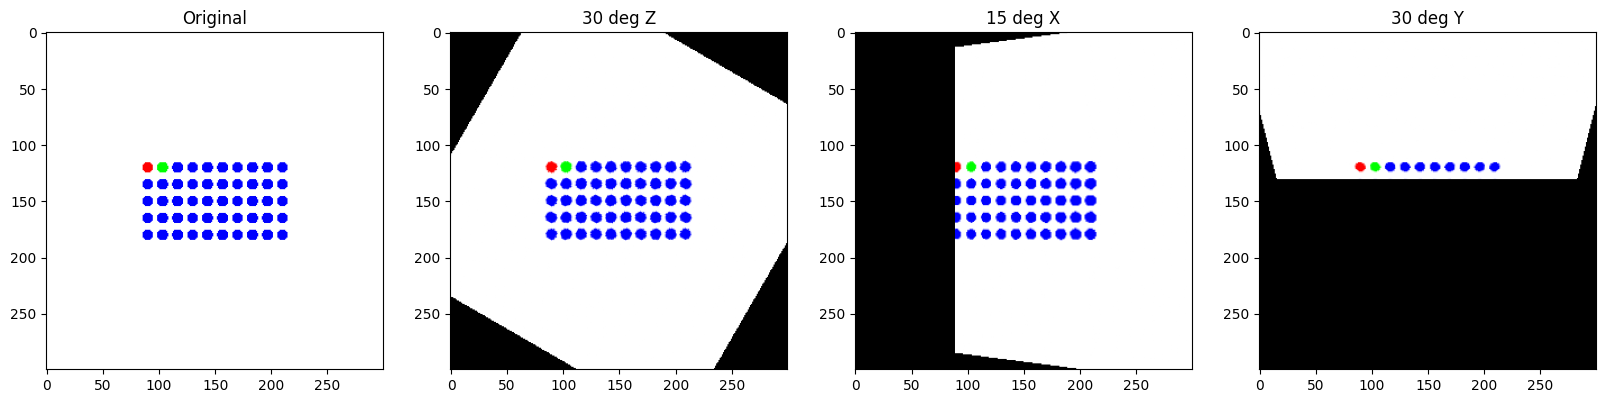

In [7]:
plot_multiple_images(image_orig, rectified_image_30z, rectified_image_15x, rectified_image_30y, titles=['Original', '30 deg Z', '15 deg X', '30 deg Y'])

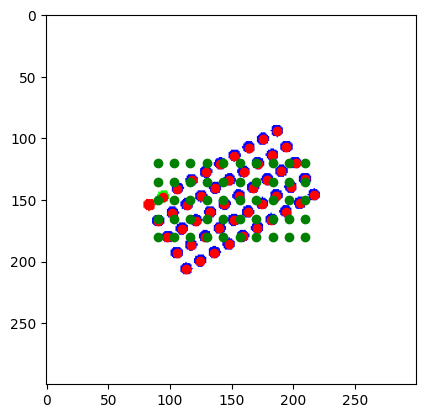

In [8]:
plt.imshow(image_30z)
plt.scatter(points_2d_30z[:, 1], points_2d_30z[:, 0], c='r')

rectified_points = np.hstack([points_2d_30z, np.ones((points_2d_30z.shape[0], 1))]) @ H_30z.T
rectified_points = rectified_points[:, :2] / rectified_points[:, 2].reshape(-1, 1)
plt.scatter(rectified_points[:, 1], rectified_points[:, 0], c='g')

In [9]:
calibrate(points_2d_orig, points_2d_30z, points_2d_15x)

array([[ 3.00000000e+02, -1.30229161e-11,  1.50000000e+02],
       [-4.09310189e-14,  3.00000000e+02,  1.50000000e+02],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])